# K-Clique

### Definition

We are given an undirected graph with vertex set $V$ and edge set $E$.

Our aim is to find out whether there exists a complete subgraph of size $K$ in this graph. 

### Applications

The Clique problem is important in areas like Bioinformatics, Computational Chemistry, Motion Segmentation and for finding structures in a graph. For example, anomalously large cliques in a network may be a sign that the underlying node connectivity is not random.

### Path to solving the problem
K-Clique can be formulated as a maximization problem and its cost function can be cast to a QUBO problem through its respective Hamiltonian (see the [Introduction](./introduction.ipynb) and a [reference](https://arxiv.org/abs/1302.5843)),

$$ \displaystyle \large
H = A \displaystyle \left( K - \textstyle\sum\limits_{v} x_v \right) ^2 + B \left[ \frac{K(K-1)}{2} - \textstyle\sum\limits_{uv \in E}  x_u x_v \right]
$$

where $A$ and $B$ are positive constants, $v, u \in V$ and $x_v$ is a binary variable, which is $1$ if vertex $v$ is part of the clique and $0$ if it is not. For a valid encoding, the constants $A$ and $B$ need to obey the relation $$A > B * K$$

Otherwise, if the rule is not followed, the spin configuration for the lowest energy $H$ may not correspond to the best solution of our K-Clique problem or even to a valid one. At the same time, it should not be overspecified, i.e. the left side being much bigger than the right side. If  $A$ is much larger, this would cause a large energy separation in $H$, impeding our solution approach.

The myQLM allows us to encode a problem in this Hamiltonian form by using the `KClique` class for a given graph, clique size $K$ and constants $A$ and $B$. We can then create a job from the problem and send it to a Simulated Annealer (SA) wrapped with a Quantum Processing Unit (QPU) interface. The SA will minimize the Hamiltonian, hence we find the solution to our problem.

In fact, the QLM contains an even more powerful solver $-$ Simulated Quantum Annealing (SQA). This quantum annealer has been tested on numerous benchmarks for the NP problems supported and produces results with a quality usually exceeding $98\%$. More details can be found in the [documentation](https://myqlm.github.io/advanced_combinatorial_optimization.html#simulated-quantum-annealing-benchmarking-and-performance).

### Quantum resources

To represent the problem as QUBO the QLM would need $N$ spins $-$ one for each of the $N$ vertices. 

# Example problem

Imagine we are given a graph with $6$ vertices and $7$ edges, as shown below (left) and we want to find a complete subgraph of size $K = 3$. For this problem, the solution is straightforward $-$ one can notice that nodes $0$, $1$ and either $2$ or $5$ constitute such a complete graph (right).

<br><img src="./k_clique_example_solution.png" style="width: 850px"><br>

However, let us describe a procedure, which will allow us to find if there are complete subgraphs of any size in whatever graph!

We will start by specifying a graph with the `networkx` library, which should give us a huge scope for graph exploration.  One can also choose the size $K$ of the desired subgraph and the constants $A$ and $B$ accordingly.

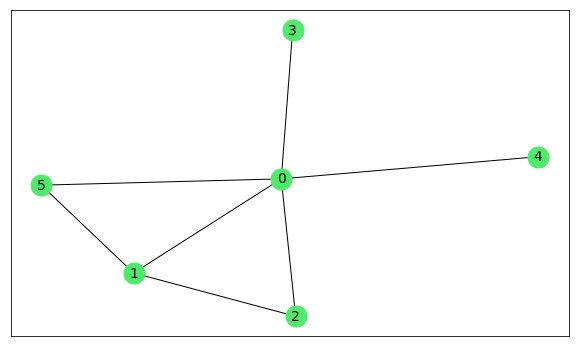

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Specify the graph 
# First example
graph = nx.Graph()
graph.add_nodes_from(np.arange(5))
graph.add_edges_from([(0, 1), (0, 2), (0, 3), (0, 4),
                      (0, 5), (1, 2), (1, 5)])

# # Second example - one may try with K = 6
# graph = nx.gnm_random_graph(15, 65)

# Specify the size of the desired subgraph
K = 3

# Impose constraints for the right encoding
B = 1
A = B * K + 1

# Draw the graph
nodes_positions = nx.spring_layout(graph, iterations=len(graph.nodes())*60)
plt.figure(figsize=(10, 6))
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 node_color='#4EEA6A', 
                 node_size=440, 
                 font_size=14)
plt.show()

To encode the problem as QUBO, we will call the `KClique` class.

In [3]:
from qat.opt import KClique

kclique_problem = KClique(graph, K, A, B)

# Solution

We can now proceed to compute the solution of the problem by the following procedure:

1. Extract some fine-tuned parameters for K-Clique (found for SQA) which are needed for the temperature schedule.


2. Create the temperature schedule using the `t` time variable (instance of the class `Variable`) and thus the `SimulatedAnnealing` QPU.


3. Create a job from the problem by calling the `to_job()` method and send it to the QPU.


4. Extract the `Result` and present the solution spin configuration and a list of the respective coloured vertices.


5. Show the graph with the nodes of the complete subgraph coloured.

Each spin from the solution configuration corresponds to a node from the graph at the same position. Note that if the numbering of the input nodes starts from $1$ and not from $0$, one still needs to look at the $0$th spin to extract information for this first node, numbered as $1$.

When a spin has the value of $1$, this means that the respective node should be coloured and is part of the complete subgraph.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: gamma_t is needed for SQA.


Solution configuration: 
[ 1.  1. -1. -1. -1.  1.]

The nodes of the complete subgraph are:
[0 1 5]



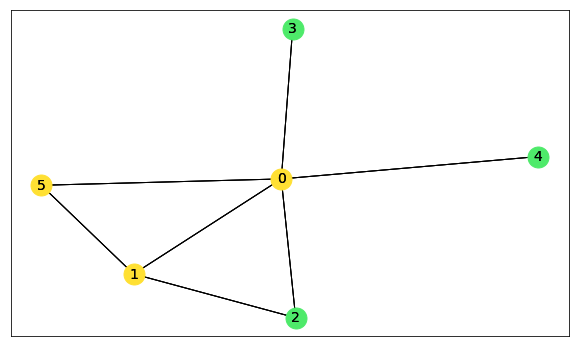

In [4]:
from qat.qpus import SimulatedAnnealing
from qat.simulated_annealing import integer_to_spins
from qat.core import Variable

# 1. Extract parameters for SA
problem_parameters_dict = kclique_problem.get_best_parameters()
n_steps = problem_parameters_dict["n_steps"]
temp_max = problem_parameters_dict["temp_max"]
temp_min = problem_parameters_dict["temp_min"]

# 2. Create a temperature schedule and a QPU
tmax = 1.0
t = Variable("t", float)
temp_t = temp_min * (t / tmax) + temp_max * (1 - t / tmax)
sa_qpu = SimulatedAnnealing(temp_t=temp_t, n_steps=n_steps)

# 3. Create a job and send it to the QPU
problem_job = kclique_problem.to_job(tmax=tmax)
problem_result = sa_qpu.submit(problem_job)

# 4. Extract and print the solution configuration
state = problem_result.raw_data[0].state.int  # raw_data is a list of Samples - one per computation
solution_configuration = integer_to_spins(state, len(graph.nodes()))
print("Solution configuration: \n" + str(solution_configuration) + "\n")
indices_spin_1 = np.where(solution_configuration == 1)[0]
print("The nodes of the complete subgraph are:\n" + str(indices_spin_1) + "\n")

# 5. Show the coloured subgraph
plt.figure(figsize=(10, 6))
node_size = 440
font_size = 14
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 nodelist=indices_spin_1.tolist(), 
                 node_color='#FFE033', 
                 node_size=node_size, 
                 font_size=font_size)

indices_spin_minus_1 = np.where(solution_configuration == -1)[0]
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 nodelist=indices_spin_minus_1.tolist(), 
                 node_color='#4EEA6A', 
                 node_size=node_size, 
                 font_size=font_size)

nx.draw_networkx_edges(graph, pos=nodes_positions)
plt.show()

# Solution analysis

For graphs which are quite big, visual examination may be problematic. We can therefore perform a few simple checks so assess the solution. Namely, whether the subgraph found is indeed complete and indeed has $K$ nodes.

It may happen that the solver finds a complete graph with a smaller size than expected. One may then increase $K$ to obtain a complete graph with the desired initial size.

In [5]:
number_of_subgraph_nodes = len (indices_spin_1)
print("Size of the subgraph:\n" + str(number_of_subgraph_nodes))

from itertools import combinations
missing_edges_list = []
for node_1, node_2 in combinations(indices_spin_1, 2):
    if (node_1, node_2) not in graph.edges() and (node_2, node_1) not in graph.edges() :
        missing_edges_list.append((node_1, node_2))

if len(missing_edges_list) == 0:
    print ("The subgraph is complete!")
else:
    print("However, there are " + "\033[1m" + str(len(missing_edges_list)) + 
      "\033[0;0m" + " missing edges for the subgraph of this size to be complete.")
    print("They are:")
    for missing_edge in missing_edges_list: print(missing_edge)

Size of the subgraph:
3
The subgraph is complete!
